# Project 6 Capstone: Improve search performance using image recognition

---

## Problem


Iamge recognition is widely used and it improves our search performance a lot.
One major use case of image recogition is deployment on EC site. Some EC sites such as Amazon, ZARA, has a search option where you can upload a picture of items that you want to buy and then the website will look for the items or similar items for you.

Especially it is deployed on many fashion related EC sites because it is common to happen that you are not sure what brand the good looking jacket is and it is difficult to describe how it looks.
You could not find the jacket describing that the jacket is green, made with silk or else because all of these features can be applied on many various kinds of cloths. It is very helpful if you can use a picture of the jacket and the websites find it for you.

I worked on to create similar function using a multi-classification model trained with images of several sightseeing objects. This model recognizes which object is in a picture. For this model, convolutional neural network is appropriate as this predicts based on images

One initial technical problem is that I could not deal with very many kinds of sightseeing objects due to machine spec and time constraint so that I chosed only 10 objects which are somewhat related.

After all I decided to use 10 kinds of cathedrals as these are famous places for visitors and I bet their appearances are relatively similar to one another so that many visitors could be confused when they want to go certain cathedral.

**Summary**

* Purpose: Model which recognizes cathedrals with its image
* Method: Multi-classification model with convolutional neural network.
* Metric: Accuracy

---

## Process
1. Data collecting
    1. Gather 10 kinds of cathedrals
2. EDA
    1. Filter images which are not `RGB`
    2. Resize to `256 x 256`
3. Modeling
---

In [1]:
import os
import requests
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

---

## Data collecting


I will gather images of 10 cathedrals from Google search result using [Image Downloader](https://chrome.google.com/webstore/detail/image-downloader/cnpniohnfphhjihaiiggeabnkjhpaldj)

Some images has a front side of an object, some has back side of the object and some others are taken at very far away. If I take all of these images into my model together, it would not learn effectively so that I need to gather images which are visually similar.

Below 2 images contain same object, but it looks different as they were taken at different angle and distance. Also second one is colored by light.
Using data set of these combination would not be rational so that I gather images similar to first one.

<img src="https://github.com/noah992/Capstone/blob/master/assets/data-collecting-01.JPG?raw=true" width="200pt"> <img src="https://github.com/noah992/Capstone/blob/master/assets/data-collecting-02.JPG?raw=true" width="300pt">

### These are the cathedrals that I will train a model with.

|Cathedral|
|-|
|The Cathedral Church of St. John the Divine|
|Catedral Metropolitana Nossa Senhora Aparecida|
|Patrick’s Cathedral|
|Catedral de La Plato|
|Cathedral Basilica of the Sacred Heart|
|Cathédrale Notre-Dame de Chartres|
|Cattedrale di Santa Maria del Fiore|
|Kölner Dom|
|St. Paul's Cathedral|
|Patriarchal Cathedral ST. Alexander Nevsky|

I collected around 50 images for each. This is quite few so I duplicated the images and duplication resulted in better accuracy score so that I will keep using duplicated images

---

## EDA

### Import images of the objects

I found some images are gray scale, and some other has alpha information. I want to only have RGB images because if array shape of images are different, I cannot feed them into a model.

Third index of the data shape stores color information and this number must be same

|Color|Shape|
|-|-|
|RGBα|(1200, 450,  `4`)|
|RGB|(428, 678, `3`)|
|Gray|(564, 680, `1`)|


I will filter out images which are not `RGB` , and also convert them to `numpy` data to check the shape

In [2]:
# Function to get image and return list of numpy image data
def get_images(path):
    
    images = [] # Store binary image data
    mode = [] # Store mode of images. I will get only 'RGB' images
    
    for image in os.listdir(path):
        img = Image.open(path+image)
        if img.mode=='RGB':
            images.append(np.array(img))
            mode.append(img.mode)
                        
    # Check color scale of images. If there are gray scale (L) images, the data shape will be different so I filtered gray scale images
    print('Mode', pd.Series(mode).value_counts()) 
    
    return images

### Store images in variables
Below cell returns numbner of `RGB` images

In [3]:
patric = get_images('../image/PatricksCathedral/')
senhora = get_images('../image/Catedral Metropolitana Nossa Senhora Aparecida/')
plata = get_images('../image/Catedral de La Plata/')
basilica = get_images('../image/Cathedral Basilica of the Sacred Heart/')
chartres = get_images('../image/Cathédrale Notre-Dame de Chartres/')
santa = get_images('../image/Cattedrale di Santa Maria del Fiore/')
kolner = get_images('../image/Kölner Dom/')
paul = get_images('../image/St. Paul\'s Cathedral/')
john = get_images('../image/The Cathedral Church of St. John the Divine/')
sbeti = get_images('../image/Patriarchal Cathedral ST. Alexander Nevsky/')

Mode RGB    172
dtype: int64
Mode RGB    140
dtype: int64
Mode RGB    144
dtype: int64
Mode RGB    128
dtype: int64
Mode RGB    134
dtype: int64
Mode RGB    118
dtype: int64
Mode RGB    150
dtype: int64
Mode RGB    130
dtype: int64
Mode RGB    98
dtype: int64
Mode RGB    98
dtype: int64


### Sample of image

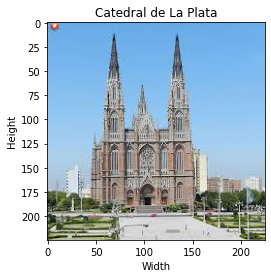

In [4]:
plt.imshow(plata[0])
plt.title('Catedral de La Plata')
plt.xlabel('Width')
plt.ylabel('Height');

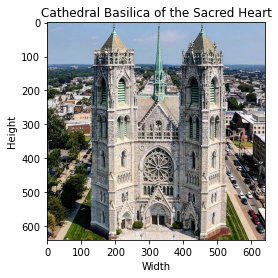

In [5]:
plt.imshow(basilica[0])
plt.title('Cathedral Basilica of the Sacred Heart')
plt.xlabel('Width')
plt.ylabel('Height');

### Reshape
Now I will check `height` and `width` of the image

In [6]:
print(plata[0].shape)
print(plata[19].shape)

(225, 225, 3)
(259, 194, 3)


All images must have same shape so I will resize images to get consistent `height` and `width`

In [7]:
# Function to trim images. This convert images to square of 256 x 256
# Also this function convert numpy data to image data

def trimming(imgs, n):
    result = Image.fromarray(imgs[n])
    return result.resize((256, 256))

### I apply above method on all images
And store all images to a list, `trim`

In [8]:
# Dictionary to store objects. This keys will be target values equivalent to the object
objects = {
    0: plata,
    1: basilica, 
    2: senhora,
    3: john,   
    4: sbeti, 
    5: patric,
    6: chartres,
    7: santa,
    8: kolner,
    9: paul,
}

In [9]:
# Trim all images and combine them into single list
trim = []
for key in objects.keys():
    for obj in range(len(objects[key])):
        trim.append(trimming(objects[key], obj))

### Before resize...

(225, 225, 3)

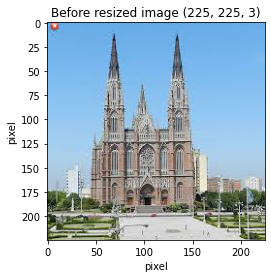

In [10]:
plt.imshow(plata[0])
plt.title('Before resized image (225, 225, 3)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plata[0].shape

### After resize

(256, 256, 3)

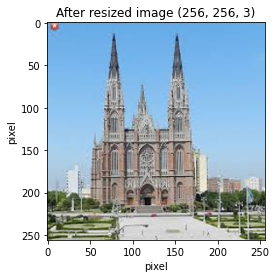

In [11]:
plt.imshow(trim[0])
plt.title('After resized image (256, 256, 3)')
plt.xlabel('pixel')
plt.ylabel('pixel')
np.array(trim[0]).shape

### Set target variable
`key` of dictionary `objects` is assigned to target value equivalent to the object

In [12]:
target = []
for value in objects.keys():
    for _ in range(len(objects[value])):
        target.append(value)

print('Count of target values')
pd.Series(target).value_counts()

Count of target values


5    172
8    150
0    144
2    140
6    134
9    130
1    128
7    118
3     98
4     98
dtype: int64

In [13]:
# Convert images to numpy data and store in pandas Series
features = pd.Series([np.array(img) for img in trim])
target = pd.Series(target)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

In [15]:
# Scale
features /= 255

In [16]:
print(features.shape)
print(features[0].shape)

(1312,)
(256, 256, 3)


### `features` has `1312` rows and each row shapes `(256, 256, 3)`. I want to convert this to `(1312, 256, 256, 3)` 

In [17]:
# Convert all images to 1 dimension
features = [i.reshape(196608) for i in features]

### Set up X and y variables

In [18]:
X = np.array(features).reshape(1312, 256, 256, 3)
y = utils.to_categorical(target)

print(X.shape)
print(X[12].shape)
print(y[0])

(1312, 256, 256, 3)
(256, 256, 3)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

### Modeling
I will use convolutional neural network model with `Keras Sequential` and `accuracy` for metric.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
# After several trials with other parameters, this model works good
cnn = Sequential()
cnn.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(256, 256, 3)))
cnn.add(MaxPooling2D(pool_size=(10,10))) 
cnn.add(Conv2D(256, kernel_size=(5,5),  activation='relu'))
cnn.add(MaxPooling2D(pool_size=(10,10)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(10, activation='softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, batch_size=128, validation_data=(X_test, y_test), epochs=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 7s 874ms/step - loss: 2.3067 - accuracy: 0.1209 - val_loss: 2.2859 - val_accuracy: 0.1311
Epoch 2/50
8/8 [==============================] - 7s 845ms/step - loss: 2.2797 - accuracy: 0.1402 - val_loss: 2.2910 - val_accuracy: 0.1220
Epoch 3/50
8/8 [==============================] - 7s 847ms/step - loss: 2.2544 - accuracy: 0.1524 - val_loss: 2.2473 - val_accuracy: 0.2134
Epoch 4/50
8/8 [==============================] - 7s 843ms/step - loss: 2.1919 - accuracy: 0.2144 - val_loss: 2.2082 - val_accuracy: 0.1372
Epoch 5/50
8/8 [==============================] - 7s 848ms/step - loss: 2.0809 - accuracy: 0.2947 - val_loss: 2.0417 - val_accuracy: 0.2835
Epoch 6/50
8/8 [==============================] - 7s 856ms/step - loss: 1.9502 - accuracy: 0.2825 - val_loss: 1.9276 - val_accuracy: 0.2988
Epoch 7/50
8/8 [==============================] - 7s 877ms/step - loss: 1.8236 - accuracy: 0.3496 - val_loss: 1.8147 - val_accuracy: 0.3110
Epoch 8/50
8/8 [====

## Result
`90%` accuracy

---

## Reccomendation

I made an app to demonstrate how you could use the image recognition on your website.

[Visit to demonstration](https://github.com/noah992/Capstone/blob/master/assets/demonstration.gif)

In this app, I fed an url of image of a cathedral which is located in Brazil.


You can see what image I fed on the second screen.
This app loaded the image and neural network model which I assembled worked on the background and generated a prediction of what the object was in the image.
Based on the result of the prediction, it navigated you to the location on google map.

You may consider to deploy image recognition as search option as it definitely improve user experience.
As I mentioned in `Problem`, visitors could not be sure which cathedral is which as they looks similar so it could be hard to identify a cathedral for them by searching with keywords however, they would be happy using image search because it would be much easier and faster for this case

---

## Next step

I used images which are taken at similar angle, similar distance and similar color. So if I feed images which were taken in different angle or with different light color, this model is likely to fail to predict correct location.

I can surely improve the accuracy by feeding more training images, and also it will be more useful to train with various kinds of pictures in terms of angle and color because this model will be more flexible on picture variations